In [1]:
from ai import Model
from api import WeatherApi
from gpx import GPXParser

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import sklearn as sk

In [ ]:
api = WeatherApi()
parser = GPXParser(api)

# tracks = parser.parse_gpx_dir("data/bike")
tracks = [parser.parse_gpx_file("data/bike/cu_martoaga_la_deal.gpx")]
for track in tracks:
    name = track["filename"][0]
    GPXParser.plot_gpx(track)

data = pd.concat(tracks, ignore_index=True)

In [ ]:
display(data[data["elapsed_time"].diff() > 60])

In [ ]:
X = data[["incline", "elapsed_time", "temperature", "wind_course_diff", "wind_speed"]]
y = data["speed"]

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X.values, y, test_size=0.2
)

In [ ]:
model = Model.create(n_estimators=100)
model.fit(X_train, y_train)

In [ ]:
model.display_stats(X_train, y_train, X_test, y_test)

In [ ]:
for track in tracks:
    X = track[
        ["incline", "elapsed_time", "temperature", "wind_course_diff", "wind_speed"]
    ]
    y = track["speed"]
    print(model.score(X.values, y))

In [2]:
G = ox.graph_from_place("Prahova, Romania", network_type="bike")

In [3]:
G = ox.elevation.add_node_elevations_raster(G, "PH.tif")

In [ ]:
ox.plot_graph(G)

In [4]:
comarnic = ox.nearest_nodes(G, 25.633, 45.242)
tesila = ox.nearest_nodes(G, 25.719, 45.297)
mec = ox.nearest_nodes(G, 26.025, 44.9405)

In [ ]:
route = ox.nearest_nodes(G, data["longitude"], data["latitude"])

In [5]:
model = Model.load(".cache/model.pkl")

In [40]:
from heapq import heappush, heappop

def dist(G, src, dst, elapsed_time):
    edge_data = G[src][dst]
    length = edge_data[0]["length"]
    altdiff = G.nodes[dst]["elevation"] - G.nodes[src]["elevation"]
    incline = altdiff / length * 100
    speed = (
        model.predict(np.array([[incline, elapsed_time, 20, 0, 0]]).reshape(1, -1))
        / 3.6
    )  # Convert km/h to m/s

    return length / speed[0]

def heuristic(G: nx.MultiDiGraph, source, target):
    # Using Euclidean distance as a heuristic
    # metric distance
    
    x1, y1 = (G.nodes[source]["x"], G.nodes[source]["y"])
    x2, y2 = (G.nodes[target]["x"], G.nodes[target]["y"])
    distance = ox.distance.great_circle(y1, x1, y2, x2)
    return distance / 20  # Assuming max speed of 50 km/h


def astar(G: nx.MultiDiGraph, source: int, target: int):
    # (heuristic_time, elapsed_time, node, path)
    queue = [(heuristic(G, source, target), 0, source, [source])]
    global visited
    visited = set()

    while len(queue) > 0:
        x, elapsed_time, node, path = heappop(queue)
        # print("estimated remaining time:", x)

        if node == target:
            return path
        
        if node in visited:
            continue

        visited.add(node)

        for neighbor in G.neighbors(node):
            neigh_elapsed_time = elapsed_time + dist(G, node, neighbor, elapsed_time)
            heappush(
                queue,
                (
                    neigh_elapsed_time + heuristic(G, neighbor, target),
                    neigh_elapsed_time,
                    neighbor,
                    path + [neighbor],
                ),
            )

In [43]:
pth = astar(G, tesila, mec)

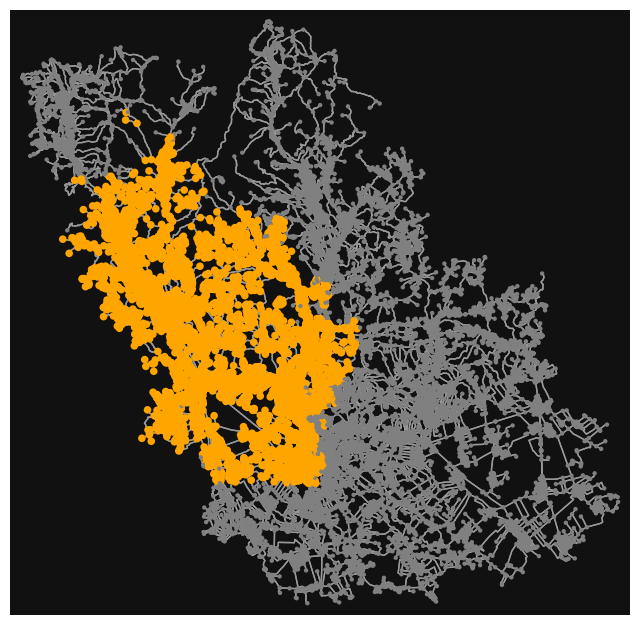

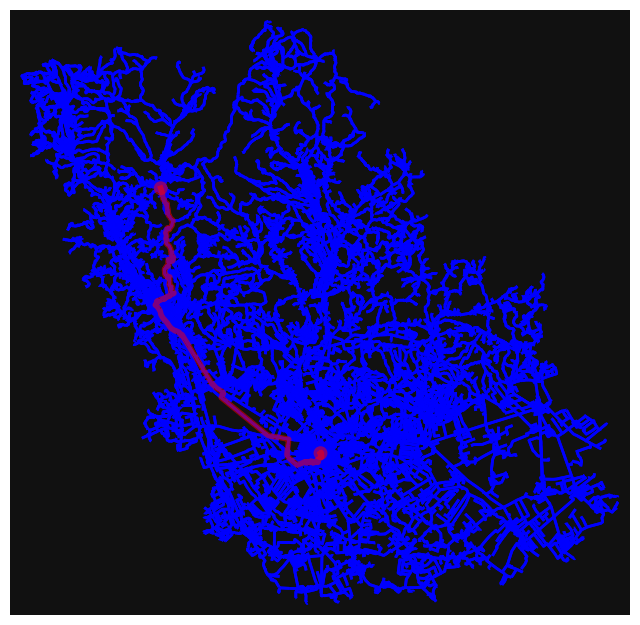

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [45]:
ox.plot_graph(
    G,
    node_color=["orange" if n in visited else "gray" for n in G.nodes],
    node_size=[30 if n in visited else 10 for n in G.nodes],
)

ox.plot_graph_route(
    G,
    pth,
    node_color="red",
    node_size=0,
    edge_color="blue",
    edge_linewidth=2,
    route_linewidth=4,
)

In [49]:
def estimate_route_time(G: nx.MultiDiGraph, path: list[int]) -> float:
    total_time = 0.0
    for i in range(len(path) - 1):
        src, dst = path[i], path[i + 1]
        edge_data = G[src][dst]
        length = edge_data[0]["length"]
        altdiff = G.nodes[dst]["elevation"] - G.nodes[src]["elevation"]
        incline = altdiff / length * 100
        speed = (
            model.predict(np.array([[incline, total_time, 20, 0, 0]]).reshape(1, -1))
            / 3.6
        )  # Convert km/h to m/s
        total_time += length / speed[0]
    return total_time

In [50]:
estimate_route_time(G, pth)

np.float64(9983.290962120935)